<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/main/AA_Reduced_Order_L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuron

In [2]:
!git clone https://github.com/chenziao/Stylized-Cell-Inference.git
%cd Stylized-Cell-Inference/

fatal: destination path 'Stylized-Cell-Inference' already exists and is not an empty directory.
/content/Stylized-Cell-Inference


In [3]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from typing import Optional, List, Tuple, Union

from cell_inference.config import params, paths
from cell_inference.cells.simulation import Simulation, Simulation_stochastic
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.utils.currents.pointconductance import PointConductance
from cell_inference.utils.metrics.measure_passive_properties import measure_passive_properties
from cell_inference.utils.metrics.measure_segment_distance import measure_segment_distance
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp
import cell_inference.utils.feature_extractors.SummaryStats2D as ss2
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.plotting.plot_variable_with_morphology import plot_variable_with_morphology
from cell_inference.utils.plotting.plot_results import plot_lfp_heatmap, plot_lfp_traces
from cell_inference.utils.transform.data_transform import log_modulus

h.load_file('stdrun.hoc')
source_directory = os.path.join('cell_inference', 'resources', 'compiled', 'mechanisms_reduced_order')
os.chdir(source_directory)
os.system(f"nrnivmodl > /dev/null 2>&1")
os.chdir("../../../../")
h.nrn_load_dll(paths.COMPILED_LIBRARY_REDUCED_ORDER)
geo_standard = pd.read_csv(paths.GEO_REDUCED_ORDER, index_col='id')
params.DT = 0.1 # comment for default
h.dt = params.DT
h.steps_per_ms = 1/h.dt

h.tstop = 2000.

### Setup smiulation parameters

In [4]:
# Biophysical parameters
filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5_stochastic.json' # active dendrites
# filepath = './cell_inference/resources/biophys_parameters/ReducedOrderL5.json' # higher gNa dendrites
with open(filepath) as f:
    biophys_param = json.load(f)

In [5]:
biophys = [2.04, 0.0213 * 0.6, 0.0213 * 0.6, 0.693 * 2, 0.000261 * 2, 100., 100., 0.0000525, 0.000555, 0.0187, # 2.04, 0.0639, 0.693 (1.0), 0.000261
          np.nan, np.nan, np.nan, np.nan, .6, 2.4]
# biophys = []
biophys_comm = {}

# interpret_params = False  # not using parameter interpreter
# geo_param = [135, 652, 163, 1.77, 1.26, .99] # 5 - 595 um
interpret_params = True  # using parameter interpreter
# geo_param = [1000, 1.]  # total length, radius scale
geo_param = [950., 0.142, 1., 0.59]  # total length 100-1200, prox prop 0.02-0.35, radius scale 0.4-1.5 (0.6-1.2), dist/prox radius 0.4-0.8 [950., 0.142, 1., 0.59]

loc_param = [0., 0., 0., 0., 1., 0.] # position (x,y,z,alpha,h,phi)

In [6]:
ncell = 0
biophys_rep = np.tile(biophys,(ncell, 1))
# biophys_rep[:,5] = np.linspace(200, 300, ncell)
biophys = np.vstack((biophys_rep, biophys))
print(biophys)

[[2.040e+00 1.278e-02 1.278e-02 1.386e+00 5.220e-04 1.000e+02 1.000e+02
  5.250e-05 5.550e-04 1.870e-02       nan       nan       nan       nan
  6.000e-01 2.400e+00]]


In [7]:
geo_param_rep = np.tile(geo_param,(ncell,1))
# geo_param_rep[:,6] = np.linspace(.1, .2, ncell)
# geo_param_rep[:,[2,3,4,6]] *= 1.0 # scale radius
geo_param = np.vstack((geo_param_rep, geo_param))
print(geo_param)

[[9.50e+02 1.42e-01 1.00e+00 5.90e-01]]


In [8]:
Len = {'p': 100 + 20, 'b': 100, 'a': 250}
# Len = {'p': 40 + 20, 'b': 160, 'a': 250}
# exc: apical / basal (#syn * PSC * FR * Prob / length)
print((7440 * 26 / Len['a']) / (4650 * 37 / Len['b']))
# inh: basal / apical
print((7440 * 0.72/ Len['a']) / (4650 * 0.3 / Len['b']))
# inh: sama / basal
print((256 * 162 * 17 * 0.88 / Len['p']) / (1023 * 24 * 4 * 0.72 / Len['b']))

0.44972972972972974
1.536
7.311827956989249


In [9]:
attr_kwargs = {}

point_conductance_division = {'soma': [0], 'perisomatic': [1,4], 'basal': [2,3], 'apical': [7,8,9,10]}
dens_params = { # ALL SET TO 0 TO REMOVE look on github for original values
    'soma': {'g_e0': 0., 'g_i0': 0., 'std_e': 0., 'std_i': 0.},
    'perisomatic': {'g_e0': 0., 'g_i0': 0., 'std_e': 0., 'std_i': 0.},
    'basal': {'g_e0': 0., 'g_i0': 0., 'std_e': 0., 'std_i': 0.},
    'apical': {'g_e0': 0., 'g_i0': 0., 'std_e': 0., 'std_i': 0.}
}
cnst_params = {'tau_e': 2., 'tau_i': 10., 'tau_n': 40.}
has_nmda = True
lornomal_gfluct = False#True

randseed = 0

In [10]:
#biophys

In [11]:
# biophys_param # specify conductances

In [12]:
geo_standard # specify morphology

,name,type,pid,axial,L,R,ang
id,,,,,,,
0,soma,1,0,True,0.0,10.000000,0.000000
1,proxbasal,3,0,False,40.0,0.647857,-0.785398
2,midbasal,3,1,False,60.0,0.334880,-0.785398
3,distbasal,3,2,False,100.0,0.253900,-0.785398
4,proxtrunk,4,0,True,135.0,1.769400,1.570796
6,midtrunk,4,4,True,652.0,1.259480,1.570796
7,disttrunk,4,6,True,163.0,0.990100,1.570796
8,proxtuft,4,7,False,100.0,0.387700,1.047198
9,midtuft,4,8,False,100.0,0.302560,1.047198


In [13]:
#geo_param # not sure what these are

In [14]:
sim = Simulation_stochastic(
    cell_type = CellTypes.REDUCED_ORDER,
    ncell = ncell + 1,
    geometry = geo_standard,
    electrodes = params.ELECTRODE_POSITION,
    loc_param = loc_param,
    geo_param = geo_param,
    biophys = biophys,
    full_biophys = biophys_param,
    biophys_comm = biophys_comm,
    interpret_params = interpret_params,
    interpret_type = 3,
    min_distance = params.MIN_DISTANCE,
    spike_threshold = params.SPIKE_THRESHOLD,
    cell_kwargs = {'attr_kwargs': attr_kwargs},
    point_conductance_division=point_conductance_division,
    dens_params=dens_params,
    cnst_params=cnst_params,
    has_nmda=has_nmda,
    lornomal_gfluct=lornomal_gfluct,
    tstart=200.,
    randseed = randseed
)

cell = sim.cells[-1]
print(sim.geo_param)

[[134.9        652.08       163.02         1.7694       1.35910193
    1.043946  ]]


#### Record membrane potential

In [15]:
V_rec = Recorder(cell.segments)

#### Simulation results

In [16]:
sim.run_neuron_sim()

Vm = V_rec.as_numpy()

In [17]:
# print('Spike count: %d' % (nspk))
# if nspk == 0:
#     print(f"No spikes.")#raise ValueError('No spike.')
# print('Firing rate: %.2f' % (firing_rate))

#### Membrane voltage

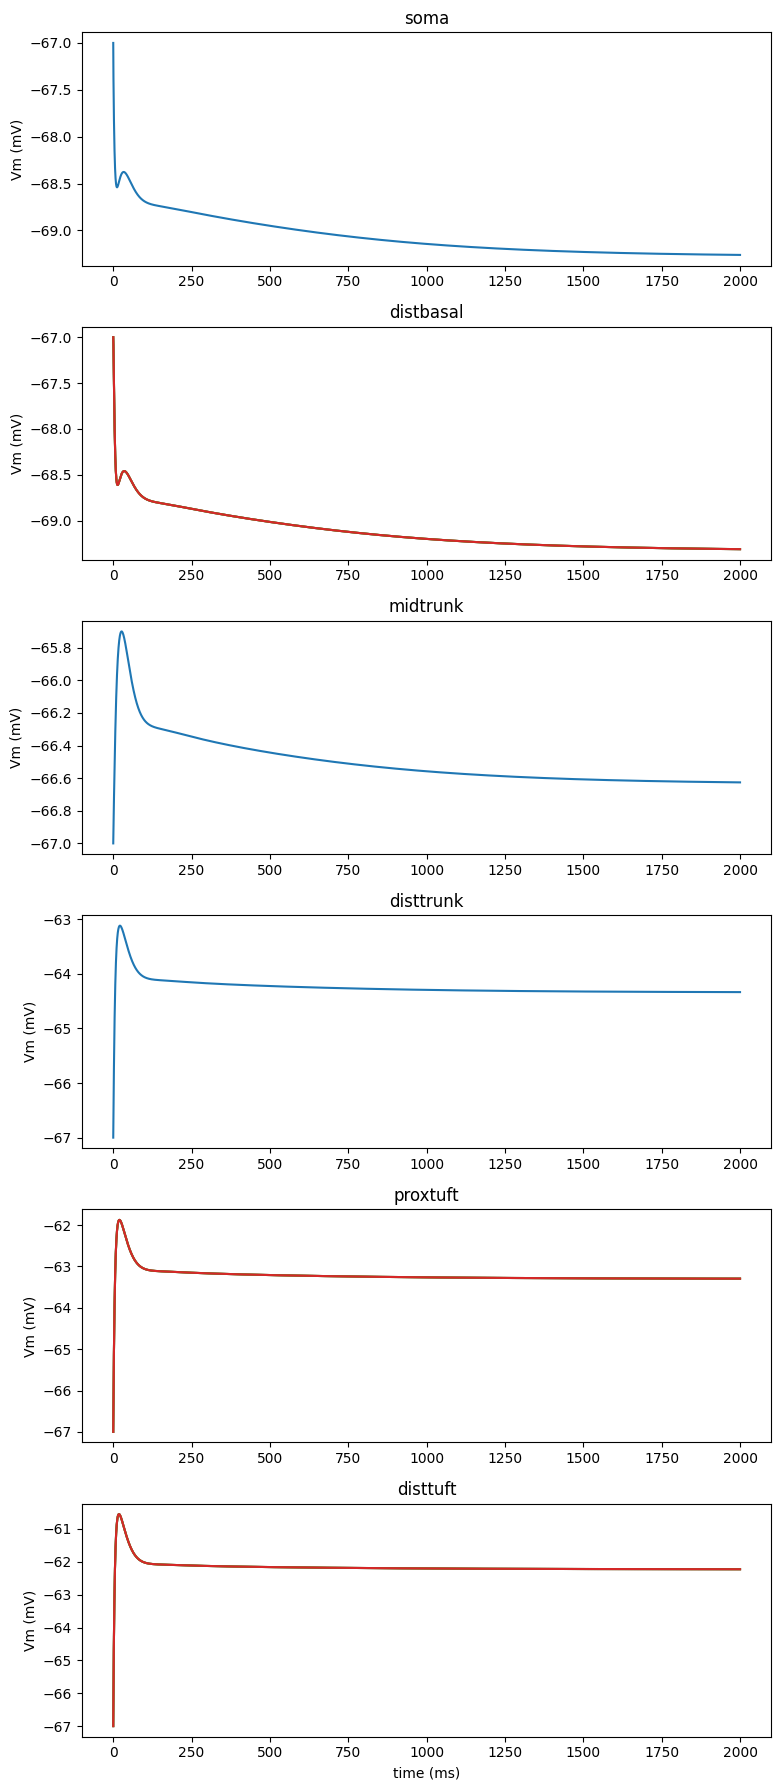

In [18]:
%matplotlib inline

plot_sec_type = [0, 3, 6, 7, 8, 10] # section type for plot membrane potential
loc = .5

n_type = len(plot_sec_type)
t = sim.t()
plt.figure(figsize=(8, 3 * n_type))
for i, type_id in enumerate(plot_sec_type):
    plt.subplot(n_type, 1, i + 1)
    for isec in cell.sec_id_lookup[type_id]:
        iseg = cell.sec_id_in_seg[isec] + int(loc * cell.all[isec].nseg)
        plt.plot(t, Vm[iseg, :])
    plt.ylabel('Vm (mV)')
    plt.title(cell.geometry.loc[type_id, 'name'])
plt.xlabel('time (ms)')
plt.tight_layout()
plt.show()

#### Calculate passive properties

In [19]:
#dir(cell.all[0])

In [20]:
import csv

# Assume cell.all is a list of sections
results = []

for sec in cell.all:
    sec_name = str(sec).split('.')[-1]

    Rm = 1/sec.g_pas
    Cm = sec.cm
    Ra = sec.Ra
    time_constant = Rm * Cm / 10000

    result = {
            'section_name': sec_name,
            'L (um)': round(sec.L, 3),
            'diam3d (um)': sec.diam3d(0),
            'Rm (MOhm)': round(Rm / 10000, 3),
            'Cm (uf/cm2)': round(Cm, 3),
            'Ra (ohm cm)': round(Ra, 3),
            'time_constant (RC)': round(time_constant, 3),
            'nseg': sec.nseg,
            'psection': sec.psection(),

            'name': sec.name()
    }
    results.append(result)

    #print(f"{sec_name}: Rm: {result['Rm_MOhm']} MOhm, Cm: {result['Cm']} µF, Ra: {result['Ra']} Ohm, Tau: {result['time_constant']} ms")

# Create the directory if it doesn't exist
!if [ ! -d "AA_output" ]; then mkdir "AA_output"; fi

# Save results to CSV
with open('AA_output/section_properties.csv', 'w', newline='') as csvfile:
    fieldnames = results[0].keys()#['section_name', 'Rm_MOhm', 'Cm', 'Ra', 'time_constant', 'diam3d', 'name, ']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for result in results:
        writer.writerow(result)

print("Results have been saved to AA_output/section_properties.csv.")

Results have been saved to AA_output/section_properties.csv.


In [21]:
for i in range(ncell):
    Vrest, Rin, Tau = measure_passive_properties(Vm[i],t,sim.cells[i].injection[0].pp_obj)
    print(Vrest, Rin, Tau)

# (-67.28648876896166, 102.19853962576195, 15.849999999985585)  # [950., 0.142, 1., 0.59] geo_param
# (-67.94989081468924, 122.86662601811145, 15.724999999985698)  # [950., 0.142, 0.7, 0.8]
# (-66.68920003388767, 66.73068344994846, 18.599999999983083)  # [1200., 0.35, 1.5, 0.8]
# (-68.18723921905612, 171.26541594565055, 14.574999999986744)  # [100., 0.02, 0.4, 0.4]

#### Get segment coordinates for given cell and calculate electrotonic distance

In [22]:
soma = cell.soma
section_list = cell.all
sec_type_swc = {sec['name']: sec['type'] for _, sec in geo_standard.iterrows()}
sec_type = [sec_type_swc[sec.name().split('.')[-1]] for sec in section_list]
freq = 0 # Hz

seg_prop, Rin, Rin_pha = measure_segment_distance(soma, section_list, sec_type, freq)
print(Rin, Rin_pha) # Megohms, rad

102.53785679316454 0.0


In [23]:
%matplotlib inline

seg_coords = cell.seg_coords
t = sim.t()
# t_idx = slice(sim.tstart, None)
t_idx = slice(None)
#im = sim.lfp[-1].calc_im()[:, t_idx]
# im_den = im / np.expand_dims(seg_prop['seg_area'], 1) # nA/um^2
#im_den = im / np.diff(seg_prop['distance'], axis=1) # nA/um

select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

#var = im_den
varname = 'Transmembrane current density per unit length (nA/um)'
axes = ['x', 'y']
n_dist = 20
max_per_dist = 1
space = 1.
normalized_space = True
sort_by_dist = True
figsize = (12, 9)
fontsize = 15
scalebar_size = 50

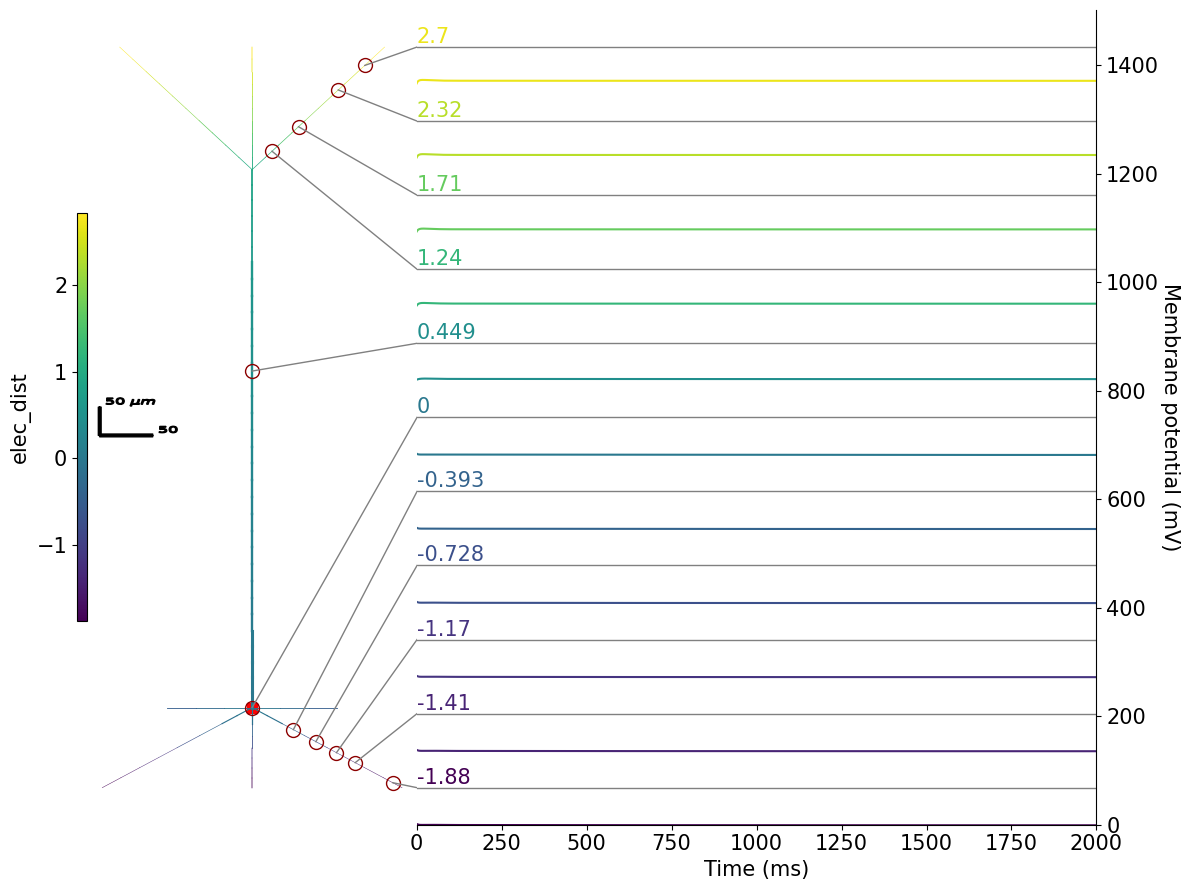

In [24]:
select_seg = None
# select_seg = seg_prop['swc_type'] != 1 # excluding soma

var = Vm[:, t_idx]
varname = 'Membrane potential (mV)'
n_dist = 12
space = 2.
normalized_space = True
sort_by_dist = True

_ = plot_variable_with_morphology(seg_coords, seg_prop, var, t=t[t_idx], axes=axes,
                                  distance_type='elec_dist', n_dist=n_dist,
                                  select_seg=select_seg, max_per_dist=max_per_dist, varname=varname,
                                  space=space, normalized_space=normalized_space, sort_by_dist=sort_by_dist,
                                  figsize=figsize, fontsize=fontsize, scalebar_size=scalebar_size)

In [25]:
spike_train = [1000]
vec = h.Vector(spike_train)
stim = h.VecStim()
stim.play(vec)
synapse = h.AlphaSynapse1(cell.soma(0.5))
netcon =h.NetCon(stim, synapse, 1, 0, 1)

In [26]:
# # spike_train = [1000]
# # vec = h.Vector(spike_train)
# # stim = h.VecStim()
# # stim.play(vec)
# # synapse = h.AlphaSynapse1(cell.soma(0.5))
# # netcon =h.NetCon(stim, synapse, 1, 0, 1)
# distances=[]
# dvsoma_by_dv_dends = []

# for i, seg in enumerate(cell.segments):
#   synapse.loc(seg)
#   dist = h.distance(synapse.get_segment(),cell.soma(0.5))
#   sim.run_neuron_sim()
#   Vm = V_rec.as_numpy()
#   original_dend_vm = Vm[i,995]
#   original_soma_vm = Vm[0,995]
#   dend_vm_max = max(Vm[i,950:])
#   soma_vm_max = max(Vm[0,950:])
#   soma_diff = soma_vm_max - original_soma_vm
#   dend_diff = dend_vm_max - original_dend_vm
#   dvsoma_by_dv_dend = soma_diff/dend_diff
#   dvsoma_by_dv_dends.append(dvsoma_by_dv_dend)
#   sec_type =
#   print(dvsoma_by_dv_dend, dist)
#   # plt.plot(t, Vm[i, :])
#   # break
#   distances.append(dist)

1.0 0.0
0.9988937135457302 19.999999997444682
0.9972785031839957 39.999999992334054
0.9988937135457302 19.999999997444682
0.9972785031839957 39.999999992334054
0.9988937135457302 19.999999997444682
0.9972785031839957 39.999999992334054
0.9988937135457302 19.999999997444682
0.9972785031839957 39.999999992334054
0.6645112696951364 64.99999998594576
0.026734405824299177 94.99999997827982
0.6645112696951364 64.99999998594576
0.026734405824299177 94.99999997827982
0.6645112696951364 64.99999998594576
0.026734405824299177 94.99999997827982
0.6645112696951364 64.99999998594576
0.026734405824299177 94.99999997827982
0.013133264530970731 122.49999997125269
0.00823217405006645 147.4999999648644
0.005874912812193594 172.4999999584761
0.004476365504697939 197.49999995208782
0.013133264530970731 122.49999997125269
0.00823217405006645 147.4999999648644
0.005874912812193594 172.4999999584761
0.004476365504697939 197.49999995208782
0.013133264530970731 122.49999997125269
0.00823217405006645 147.499999

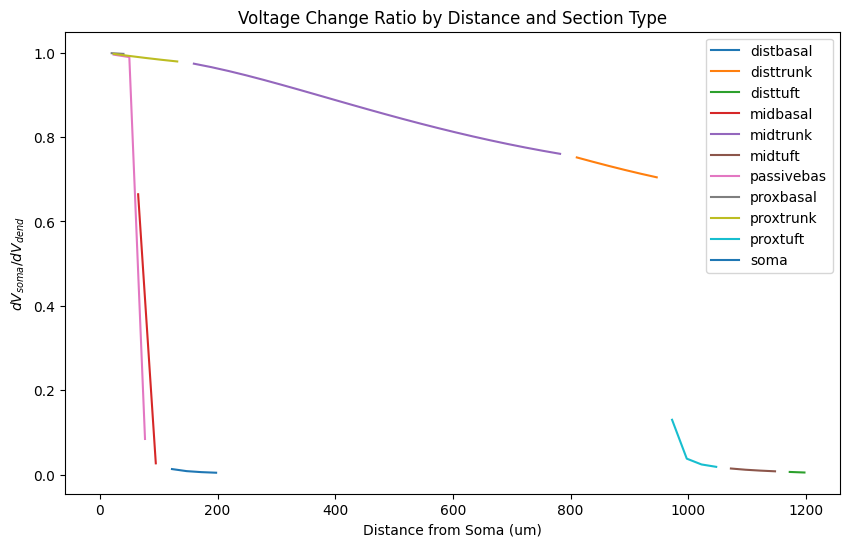

In [34]:
def get_sec_type(segment):
    # Placeholder function - replace with actual method to get section type
    return str(segment.sec).split('>.')[-1]
# Initialize lists to store data
distances = []
dvsoma_by_dv_dends = []
section_types = []

for i, seg in enumerate(cell.segments):
    synapse.loc(seg)
    dist = h.distance(synapse.get_segment(), cell.soma(0.5))
    sim.run_neuron_sim()
    Vm = V_rec.as_numpy()

    original_dend_vm = Vm[i, 995]
    original_soma_vm = Vm[0, 995]
    dend_vm_max = max(Vm[i, 950:])
    soma_vm_max = max(Vm[0, 950:])

    soma_diff = soma_vm_max - original_soma_vm
    dend_diff = dend_vm_max - original_dend_vm
    dvsoma_by_dv_dend = soma_diff / dend_diff

    sec_type = get_sec_type(seg)

    distances.append(dist)
    dvsoma_by_dv_dends.append(dvsoma_by_dv_dend)
    section_types.append(sec_type)
    print(dvsoma_by_dv_dend, dist)

# Combine lists into a structured array for easy sorting
data = np.rec.array([
    (dist, ratio, sec_type) for dist, ratio, sec_type in zip(distances, dvsoma_by_dv_dends, section_types)],
    dtype=[('distance', 'f8'), ('ratio', 'f8'), ('section_type', 'U10')]
)

# Sort data by section type and then by distance within each section type
sorted_data = np.sort(data, order=['section_type', 'distance'])

# Now, you can plot your data. Here's a basic way to do it:
plt.figure(figsize=(10, 6))
for sec_type in np.unique(sorted_data['section_type']):
    # Filter data for the current section type
    sec_data = sorted_data[sorted_data['section_type'] == sec_type]
    plt.plot(sec_data['distance'], sec_data['ratio'], label=sec_type)

plt.xlabel('Distance from Soma (um)')
plt.ylabel('$dV_{soma} / dV_{dend}$')
plt.title('Voltage Change Ratio by Distance and Section Type')
plt.legend()
plt.show()

netcon.active(False) # turn off synapse for other simulations

In [35]:
cell.injection

[]

In [ ]:
total_amp = 0
firing_rates = [0]
amplitudes = [0]
while total_amp <= 2.0:
  total_amp +=0.1
  cell.add_injection(sec_index=0, amp = 0.1, dur = 2000)
  sim.run_neuron_sim()
  Vm = V_rec.as_numpy()



  spk_window = [-2., 4.] # ms
  spk_windows, nspk = sim.get_spk_windows(-1, spk_window=spk_window)
  firing_rate = 1000. * nspk / (h.tstop - sim.tstart * h.dt)
  firing_rates.append(nspk/2)
  amplitudes.append(total_amp)

plt.figure()
plt.plot(amplitudes, firing_rates)

In [ ]:
spk_window = [-2., 4.] # ms
spk_windows, nspk = sim.get_spk_windows(-1, spk_window=spk_window)

iseg = np.array([cell.sec_id_in_seg[isec] + int(loc * cell.all[isec].nseg) for isec in cell.sec_id_lookup[plot_sec_type[0]]])
Vm_avg = np.mean([Vm[iseg, win[0]:win[1]] for win in spk_windows], axis=(0, 1))

plt.figure(figsize=(8, 3))
plt.plot(t[:Vm_avg.size], Vm_avg)
plt.ylabel('Vm (mV)')
plt.title('Averaged action potential')
plt.xlabel('time (ms)')
plt.show()

In [ ]:
%matplotlib inline

plot_sec_type = [0, 3, 6, 7, 8, 10] # section type for plot membrane potential
loc = .5

n_type = len(plot_sec_type)
t = sim.t()
plt.figure(figsize=(8, 3 * n_type))
for i, type_id in enumerate(plot_sec_type):
    plt.subplot(n_type, 1, i + 1)
    for isec in cell.sec_id_lookup[type_id]:
        iseg = cell.sec_id_in_seg[isec] + int(loc * cell.all[isec].nseg)
        plt.plot(t, Vm[iseg, :])
    plt.ylabel('Vm (mV)')
    plt.title(cell.geometry.loc[type_id, 'name'])
plt.xlabel('time (ms)')
plt.tight_layout()
plt.show()